## PCA

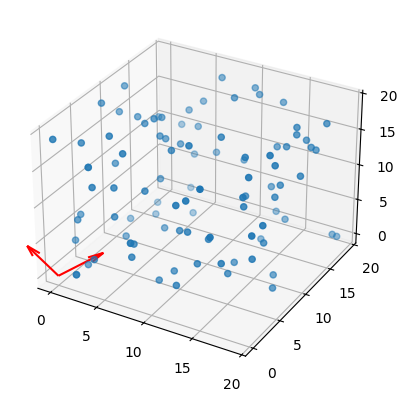

(array([0.64545676, 0.54013739, 0.54003442]),
 array([-0.48955823, -0.25014563,  0.83532024]))

In [1]:
import matplotlib.pyplot as plt
import numpy as np

X = np.random.randint(0,20,(100,3))
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]
_,ax = plt.subplots(subplot_kw={"projection":"3d"})
ax.scatter(X[:,0],X[:,1],X[:,2])
ax.quiver([0,0],[0,0],[0,0],[c1[0],c2[0]],[c1[1],c2[1]],[c1[2],c2[2]],normalize=True,length=5,color='r')
plt.show()
c1,c2

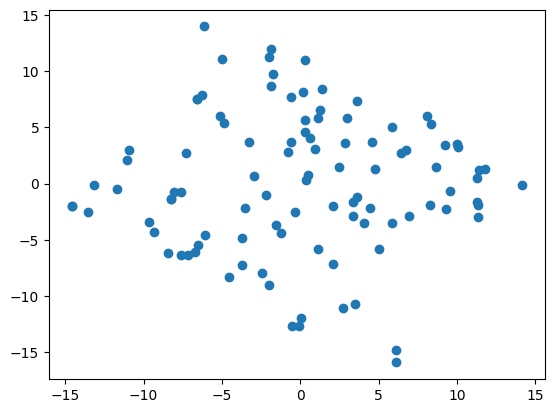

In [2]:
W2 = Vt[:2].T
X2D = X_centered @ W2
plt.scatter(X2D[:,0],X2D[:,1])

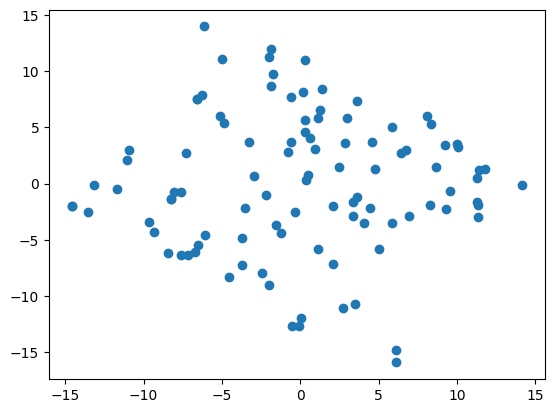

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
plt.scatter(X2D[:,0],X2D[:,1])

In [4]:
pca.explained_variance_ratio_

array([0.38543192, 0.32016948])

In [5]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000],mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:],mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax( cumsum >= 0.95 ) + 1
d

154

In [6]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [7]:
pca.n_components_

154

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10,80),
    "randomforestclassifier__n_estimators": np.arange(50,500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10,
                                cv=3,random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 475, 'pca__n_components': 57}


In [9]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)
X_reduced = inc_pca.transform(X_train)

In [10]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write',
                   shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [11]:
X_mmap = np.memmap(filename, dtype='float32',
                   mode='readonly').reshape(-1,784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## LLE

In [14]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2,random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10,random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

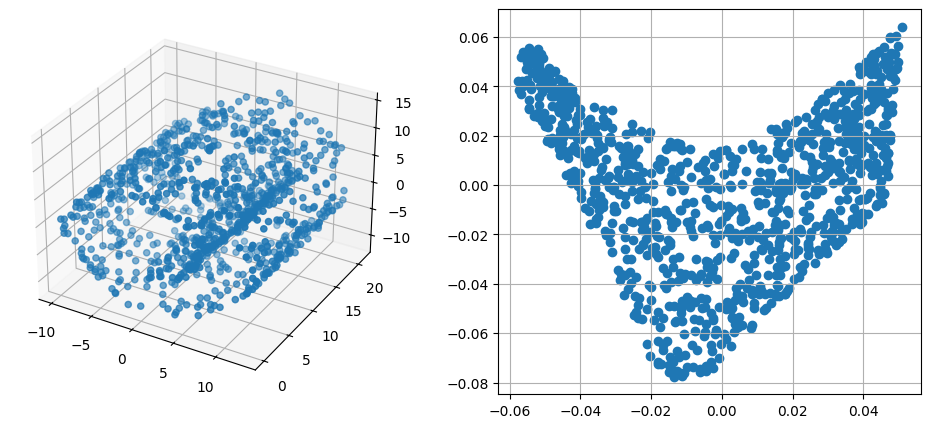

In [31]:
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(1,2,1,projection='3d')
ax1.scatter(X_swiss[:,0],X_swiss[:,1],X_swiss[:,2])
ax2 = fig.add_subplot(1,2,2)
ax2.scatter(X_unrolled[:,0],X_unrolled[:,1])
ax2.grid(True)

## Exercises

1. What	are	the	main	motivations	for	reducing	a	dataset’s	dimensionality?
   To reduce complexity and runnig time
   What	are	the	main	drawbacks?
   Information loss
2. What	is	the	curse	of	dimensionality?
   There are problems that only arise in high-dimensional spaces
3. 	Once	a	dataset’s	dimensionality	has	been	reduced,	is	it	possible	to	reverse
 the	operation?	If	so,	how?	If	not,	why?
    Due to the loss of information when reducing dimensionality, it is possible to reverse the operation
   to get ALMOST the original dataset, but it won't be the same
4. Can	PCA	be	used	to	reduce	the	dimensionality	of	a	highly	nonlinear
 dataset?
    Yes
5. Suppose	you	perform	PCA	on	a	1,000-dimensional	dataset,	setting	the
 explained	variance	ratio	to	95%.	How	many	dimensions	will	the	resulting
 dataset	have? 
    It depends on the dataset, and it varies from 1 to 950
6. In	what	cases	would	you	use	regular	PCA,	incremental	PCA,	randomized
PCA,	or	random	projection?
    Prefer regular PCA, incremental when training set is to large, and randomized PCA
   or random projection when the number of features is very large
7. How	can	you	evaluate	the	performance	of	a	dimensionality	reduction
 algorithm	on	your	dataset?
    If possible, check the reconstruction error ratio, and if DR is used as a preprocessing
   step, then evaluating the performance of the next algorithm
8. Does	it	make	any	sense	to	chain	two	different	dimensionality	reduction
 algorithms?
    Yes, it could be very useful for example runnig at first a fast algorithm and then
   a more complex one
 

9. Load	the	MNIST	dataset	(introduced	in	Chapter	3)	and	split	it	into	a
 training	set	and	a	test	set	(take	the	first	60,000	instances	for	training,	and
 the	remaining	10,000	for	testing).	Train	a	random	forest	classifier	on	the
 dataset	and	time	how	long	it	takes,	then	evaluate	the	resulting	model	on	the
 test	set.	Next,	use	PCA	to	reduce	the	dataset’s	dimensionality,	with	an
 explained	variance	ratio	of	95%.	Train	a	new	random	forest	classifier	on	the
 reduced	dataset	and	see	how	long	it	takes.	Was	training	much	faster?	Next,
 evaluate	the	classifier	on	the	test	set.	How	does	it	compare	to	the	previous
 classifier?	Try	again	with	an	SGDClassifier.	How	much	does	PCA
 help	now?

In [41]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(mnist.data,mnist.target,train_size=60000,random_state=42)

In [42]:
rf_clf = RandomForestClassifier(random_state=42)

In [43]:
%%time
rf_clf.fit(X_train,y_train)

CPU times: total: 40.4 s
Wall time: 40.4 s


RandomForestClassifier(random_state=42)

In [44]:
rf_clf.score(X_test,y_test)

0.9674

In [45]:
rf_pca = PCA(n_components=0.95,svd_solver='full')
X_reduced = rf_pca.fit_transform(X_train)

In [46]:
rf_clf2 = RandomForestClassifier(random_state=43)

In [56]:
%%time
rf_clf2.fit(X_reduced,y_train)

CPU times: total: 2min 15s
Wall time: 2min 15s


RandomForestClassifier(random_state=43)

In [58]:
X_test_reduced =  rf_pca.transform(X_test)           
rf_clf2.score(X_test_reduced,y_test)

0.9458

In [ ]:
len(rf_pca.components_)

In [54]:
from sklearn.linear_model import SGDClassifier

sgd_clf1 = SGDClassifier(random_state=42)
sgd_clf2 = SGDClassifier(random_state=43)

In [55]:
%%time
sgd_clf1.fit(X_train,y_train)

CPU times: total: 2min 16s
Wall time: 2min 16s


SGDClassifier(random_state=42)

In [59]:
%%time
sgd_clf2.fit(X_reduced,y_train)

CPU times: total: 25.5 s
Wall time: 25.6 s


SGDClassifier(random_state=43)

In [60]:
sgd_clf1.score(X_test,y_test)

0.8691

In [61]:
sgd_clf2.score(X_test_reduced,y_test)

0.8874

10. Use	t-SNE	to	reduce	the	first	5,000	images	of	the	MNIST	dataset	down	to	2
 dimensions	and	plot	the	result	using	Matplotlib.	You	can	use	a	scatterplot
 using	10	different	colors	to	represent	each	image’s	target	class.
 Alternatively,	you	can	replace	each	dot	in	the	scatterplot	with	the
 corresponding	instance’s	class	(a	digit	from	0	to	9),	or	even	plot	scaled
down	versions	of	the	digit	images	themselves	(if	you	plot	all	digits	the
 visualization	will	be	too	cluttered,	so	you	should	either	draw	a	random
 sample	or	plot	an	instance	only	if	no	other	instance	has	already	been	plotted
 at	a	close	distance).	You	should	get	a	nice	visualization	with	well-separated
 clusters	of	digits.	Try	using	other	dimensionality	reduction	algorithms,	such
 as	PCA,	LLE,	or	MDS,	and	compare	the	resulting	visualizations.

In [62]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2,random_state=42)
X_tsne = tsne.fit_transform(X_train[:5_000])

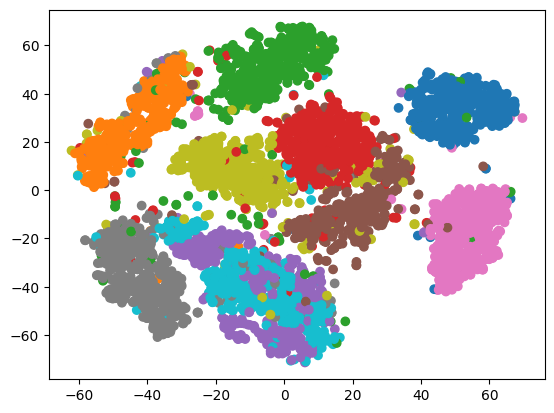

In [77]:
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y_train[:5_000].astype(int).tolist(),cmap='tab10')

In [ ]:
from sklearn.manifold import MDS

lle = LocallyLinearEmbedding(n_components=2,n_neighbors=10,random_state=42)
mds = MDS(n_components=2,random_state=42)
X_lle = lle.fit_transform(X_train[:5_000])
X_mds = mds.fit_transform(X_train[:5_000])

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].scatter(X_lle[:,0],X_lle[:,1],c=y_train[:5_000].astype(int).tolist(),cmap='tab10')
ax[1].scatter(X_mds[:,0],X_mds[:,1],c=y_train[:5_000].astype(int).tolist(),cmap='tab10')

In [ ]:
|